In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os

In [2]:
#loading comments and checking the size of data
ADHD_comments = pd.read_csv(os.getcwd()+"\\adhdwomen-comment.csv")
print(ADHD_comments.shape) 
ADHD_comments.head()

(202658, 5)


,body,id,score,created_utc,created_datetime
0,"I'd like to see this sub be more active, too. ...",cqowxhs,1,1430023102,2015-04-26 04:38:22
1,I've found people are more receptive when you ...,cvzg3v2,1,1444835103,2015-10-14 15:05:03
2,Thank you so much. I have been trying to use m...,cw65vo8,1,1445326215,2015-10-20 07:30:15
3,[deleted],d2tscyn,1,1462457040,2016-05-05 14:04:00
4,"Sooooo, not sure why you were told it was 24 h...",d38enqz,1,1463457224,2016-05-17 03:53:44


In [3]:
#remove comments which were marked deleted/removed or the bot removed them due to violating Rule 7 of Reddit.
filtered_comments = ADHD_comments[(~ADHD_comments["body"].isin(["[deleted]", "[removed]"])) & (~ADHD_comments["body"].str.contains('Rule 7'))]
filtered_comments.head()

,body,id,score,created_utc,created_datetime
0,"I'd like to see this sub be more active, too. ...",cqowxhs,1,1430023102,2015-04-26 04:38:22
1,I've found people are more receptive when you ...,cvzg3v2,1,1444835103,2015-10-14 15:05:03
2,Thank you so much. I have been trying to use m...,cw65vo8,1,1445326215,2015-10-20 07:30:15
4,"Sooooo, not sure why you were told it was 24 h...",d38enqz,1,1463457224,2016-05-17 03:53:44
5,My doctor is reluctant to give me a fast actin...,d38f9y3,1,1463458428,2016-05-17 04:13:48


In [4]:
#cleaning texts from punctuations, stop words and wiered characters and generating tokens 

import nltk
import re

from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text=re.sub(r'[^\w\s]',"",text)
    text=text.replace("\n", " ").replace("  ", " ")
    return text
def lemmas(text):
    tokens = word_tokenize(text.lower())
    doc = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return doc
def process_text(text):
    text = clean_text(text)
    text_lemmas = lemmas(text)
    return text_lemmas


In [5]:
#saving tokens in a file so that we don't need to clean texts every time!
vectors = [process_text(text) for text in filtered_comments["body"].values]
vector_df = pd.DataFrame({"index":filtered_comments.index.values, "text":filtered_comments["body"].values, "tokens":vectors})
vector_df.to_csv(os.getcwd()+"\\vectors.csv")

In [6]:
#vector_df = pd.read_csv("vectors.csv")
#vectors = vector_df["tokens"]

In [7]:
vector_df.head()

,index,text,tokens
0,0,"I'd like to see this sub be more active, too. ...","[id, like, see, sub, active, across, reddit, l..."
1,1,I've found people are more receptive when you ...,"[ive, found, people, receptive, take, responsi..."
2,2,Thank you so much. I have been trying to use m...,"[thank, much, trying, use, phone, set, alert, ..."
3,4,"Sooooo, not sure why you were told it was 24 h...","[sooooo, sure, told, 24, hour, release, ill, g..."
4,5,My doctor is reluctant to give me a fast actin...,"[doctor, reluctant, give, fast, acting, dosage..."


In [52]:
#finding most repeated tokens
tokens_series = []
for vector in vectors:
    tokens_series+=vector
tokens_series = pd.Series(tokens_series)
top_words = tokens_series.value_counts()[:100]*100/tokens_series.shape[0]
print(top_words)

im           1.410137
like         1.216410
get          0.929256
adhd         0.906246
thing        0.869060
               ...   
different    0.167969
id           0.164726
month        0.163073
said         0.160973
use          0.160757
Length: 100, dtype: float64


In [9]:
#importing tools from gensim for LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [12]:
# Creates, which is a mapping of word IDs to words.
def vector_to_corpus(vectors):
    words = corpora.Dictionary(vectors)

    # Turns each document into a bag of words.
    corpus = [words.doc2bow(doc) for doc in vectors]
    return corpus, words

In [13]:
#Training LDA
corpus,words = vector_to_corpus(vectors)
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=10, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
#printing extracted topics by LDA
lda_model.print_topics()

[(0,
  '0.028*"im" + 0.025*"like" + 0.018*"get" + 0.017*"thing" + 0.015*"dont" + 0.012*"feel" + 0.012*"really" + 0.011*"know" + 0.011*"also" + 0.011*"ive"'),
 (1,
  '0.034*"doctor" + 0.022*"psychiatrist" + 0.018*"appointment" + 0.016*"health" + 0.016*"question" + 0.016*"therapist" + 0.014*"diagnosis" + 0.013*"ask" + 0.012*"test" + 0.011*"asked"'),
 (2,
  '0.029*"brain" + 0.021*"list" + 0.021*"task" + 0.018*"focus" + 0.017*"work" + 0.016*"done" + 0.012*"write" + 0.011*"phone" + 0.011*"reading" + 0.011*"note"'),
 (3,
  '0.045*"job" + 0.040*"school" + 0.035*"kid" + 0.022*"mom" + 0.021*"parent" + 0.018*"class" + 0.018*"couldnt" + 0.016*"year" + 0.016*"child" + 0.014*"high"'),
 (4,
  '0.020*"use" + 0.018*"put" + 0.011*"house" + 0.010*"one" + 0.010*"clean" + 0.009*"stuff" + 0.008*"room" + 0.006*"cleaning" + 0.006*"buy" + 0.006*"pick"'),
 (5,
  '0.133*"thank" + 0.070*"thanks" + 0.055*"post" + 0.038*"comment" + 0.029*"omg" + 0.025*"sharing" + 0.024*"wow" + 0.024*"god" + 0.018*"appreciate" + 0.

In [36]:
#extracting the probability of topics for each text
def topic_distribution(corpus):
    return lda_model[corpus][0]

#choosing topic with the highest probability as the predicted topic
def topic_prediction(corpus):
    topics = [max(topic_distribution(c), key = lambda x : x[1]) for c in corpus]
    return topics

In [39]:
#saving predictions and their probability in a csv file
predictions = topic_prediction(corpus)
print(predictions)
topic, probabs=list(zip(*predictions))
vector_df["predicted_topic"]=topic
vector_df["predicted_probabs"]=probabs
vector_df.to_csv("predictions.csv")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [44]:
#finding the distribution of topics in the posts
vector_df["predicted_topic"].value_counts()*100/vector_df.shape[0]

0    98.978216
4     0.463536
9     0.183410
8     0.114255
7     0.112251
1     0.103231
3     0.019544
2     0.013530
5     0.009020
6     0.003007
Name: predicted_topic, dtype: float64

In [53]:
#extracting the distribution of top 50 important words in the topics.
def word_dist(words, vector_df):
    word_topic_dic = {}
    topics = vector_df.groupby("predicted_topic")
    for topic, grp in topics:        
        token_list =[]
        for tokens in grp["tokens"].values:
            token_list +=tokens
        word_topic_dic[topic] = token_list
    word_topic_dist = {}
    for word in words:
        word_topic_dist[word]={}
        for topic in word_topic_dic.keys():
                word_topic_dist[word][topic]=word_topic_dic[topic].count(word)/len(word_topic_dic[topic])
    return word_topic_dist
word_topic_distribution = word_dist(top_words.index, vector_df)

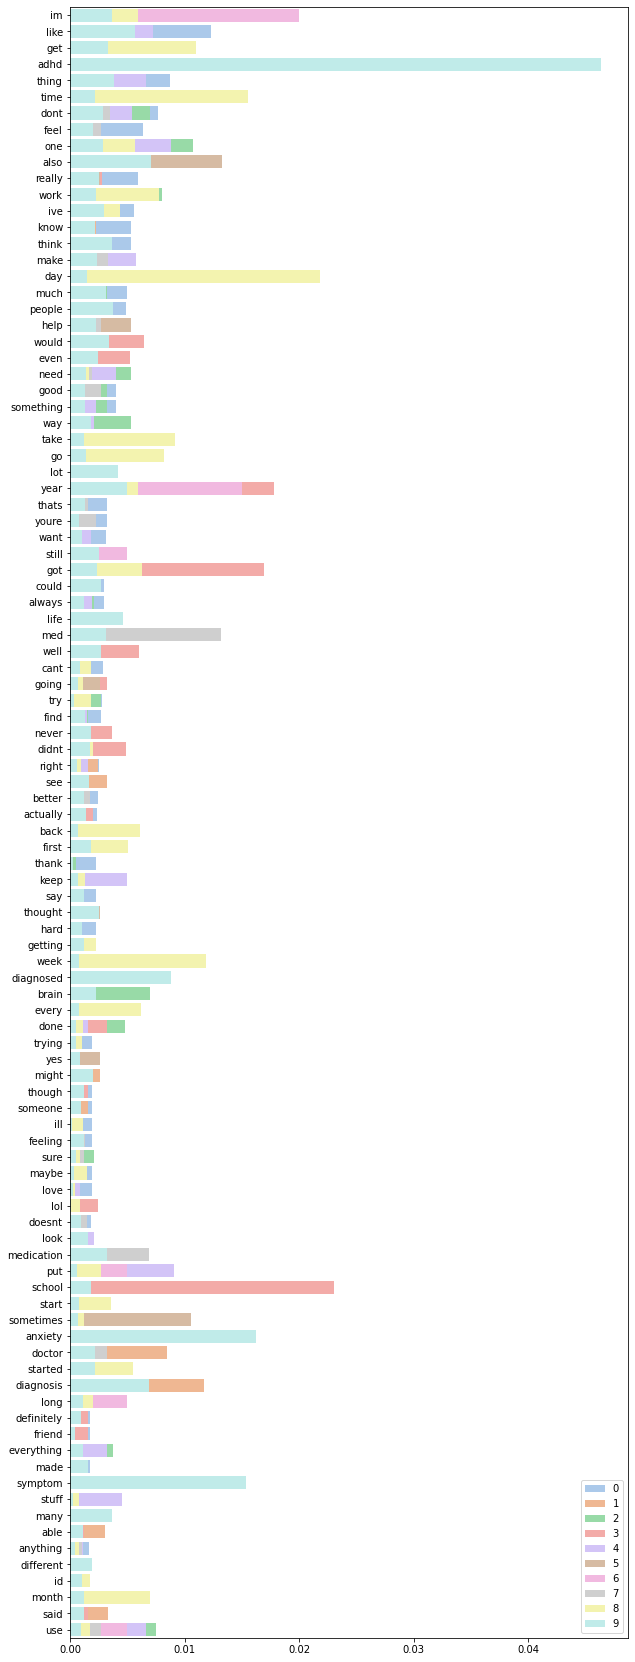

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,30))
colors = sns.color_palette("pastel")
col_no = 0
for topic in range(10):
    sns.barplot(y=top_words.index, x=[word_topic_distribution[word][topic] for word in top_words.index], color=colors[col_no], label = topic) # Your code here
    col_no+=1
plt.legend()
plt.show()